In [9]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt

import sys
sys.path.append("src/")
import gpt as g

from qcd_ml.nn.ptc import v_PTC
from qcd_ml.qcd.dirac import dirac_wilson_clover
from qcd_ml.base.paths import PathBuffer

from qcd_ml.compat.gpt import lattice2ndarray, ndarray2lattice

from qcd_ml.util.solver import GMRES_restarted

In [4]:


U = torch.tensor(np.load(os.path.join("test", "assets","1500.config.npy")))



paths = [[]] + [[(mu, 1)] for mu in range(4)] + [[(mu, -1)] for mu in range(4)]

idty = torch.complex(torch.tensor(np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]), dtype=torch.double)
                     , torch.zeros((4,4), dtype=torch.double))
zeros = torch.complex(torch.zeros((4,4), dtype=torch.double)
                     , torch.zeros((4,4), dtype=torch.double))

layer = v_PTC(1, 1, paths, U)
layer.weights.data[:,:,:] = zeros
layer.weights.data[:,:,0] = idty



In [6]:
vec = torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.cdouble)


w = dirac_wilson_clover(U, -0.58, 1.0)

U_gpt = g.load("/home/knd35666/data/ensembles/ens_001/1500.config/")
w_gpt = g.qcd.fermion.wilson_clover(U_gpt, {"mass": -0.58,
    "csw_r": 1.0,
    "csw_t": 1.0,
    "xi_0": 1.0,
    "nu": 1.0,
    "isAnisotropic": False,
    "boundary_phases": [1,1,1,1]})

w = lambda x: torch.tensor(lattice2ndarray(w_gpt(ndarray2lattice(x.numpy(), U_gpt[0].grid, g.vspincolor))))


GPT :     186.486111 s : Reading /home/knd35666/data/ensembles/ens_001/1500.config/
GPT :     186.492672 s : Switching view to [1,1,1,1]/Read
GPT :     186.534323 s : Read 0.00109863 GB at 0.0263708 GB/s (0.0637724 GB/s for distribution, 0.0449741 GB/s for reading + checksum, 2.83395 GB/s for checksum, 1 views per node)
GPT :     186.548514 s : Read 0.00109863 GB at 0.0803277 GB/s (3.99653 GB/s for distribution, 0.0819958 GB/s for reading + checksum, 0.926417 GB/s for checksum, 1 views per node)
GPT :     186.561942 s : Read 0.00109863 GB at 0.0900668 GB/s (2.20268 GB/s for distribution, 0.0939277 GB/s for reading + checksum, 3.31034 GB/s for checksum, 1 views per node)
GPT :     186.574291 s : Read 0.00109863 GB at 0.0950456 GB/s (3.10303 GB/s for distribution, 0.0980718 GB/s for reading + checksum, 3.94183 GB/s for checksum, 1 views per node)
GPT :     186.575014 s : Completed reading /home/knd35666/data/ensembles/ens_001/1500.config/ in 0.0934706 s


In [7]:
import time

start = time.perf_counter_ns()
w(vec)
stop = time.perf_counter_ns()
print((stop - start) / 1000 / 1000)

33.347142


In [8]:
def complex_mse_loss(output, target):
    err = (output - target)
    return (err * err.conj()).real.sum()

def l2norm(v):
    return (v * v.conj()).real.sum()


In [15]:
x, ret = GMRES_restarted(w, vec, vec, eps=1e-4, max_restart=500 // 20, maxiter_inner=30)
ret

{'converged': True, 'k': 572, 'res': tensor(9.9840e-05, dtype=torch.float64)}

W0731 16:56:46.498000 140285037066048 torch/_dynamo/convert_frame.py:762] [5/8] torch._dynamo hit config.cache_size_limit (8)
W0731 16:56:46.498000 140285037066048 torch/_dynamo/convert_frame.py:762] [5/8]    function: 'v_ng_evaluate_path' (/home/knd35666/physics/ML/lattice_ML/reimplement_pytorch/qcd_ml/src/qcd_ml/base/paths.py:26)
W0731 16:56:46.498000 140285037066048 torch/_dynamo/convert_frame.py:762] [5/8]    last reason: GLOBAL_STATE changed: grad_mode 
W0731 16:56:46.498000 140285037066048 torch/_dynamo/convert_frame.py:762] [5/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0731 16:56:46.498000 140285037066048 torch/_dynamo/convert_frame.py:762] [5/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.


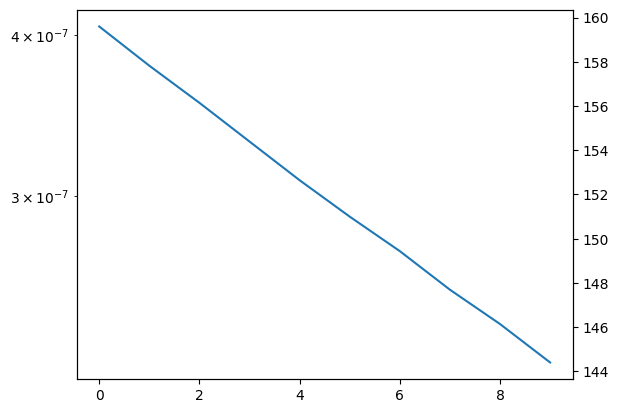

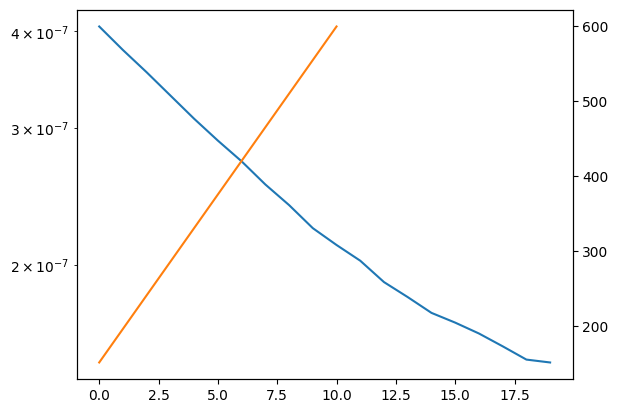

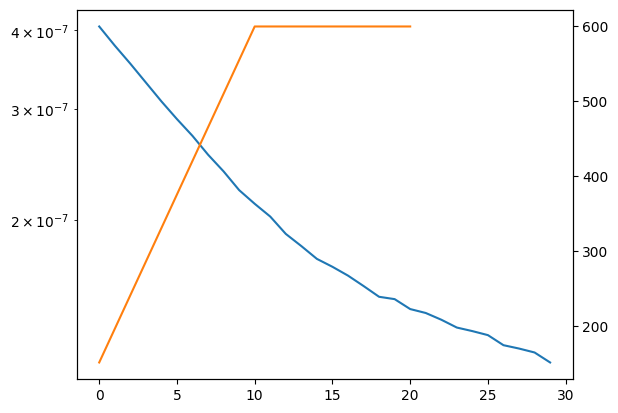

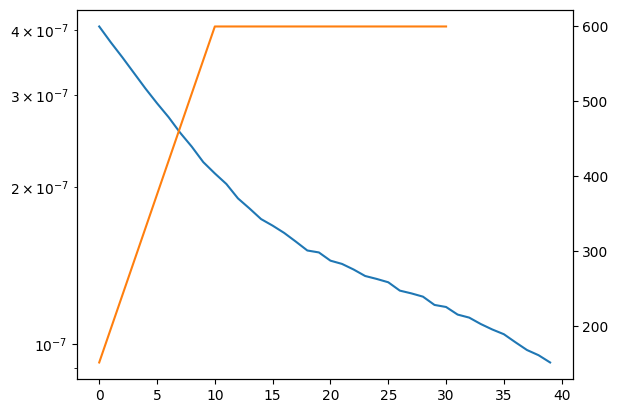

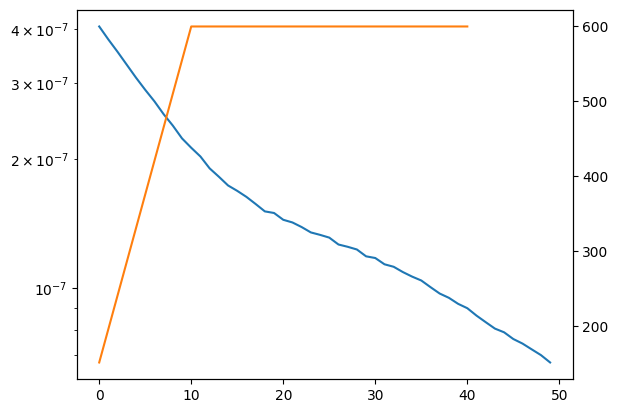

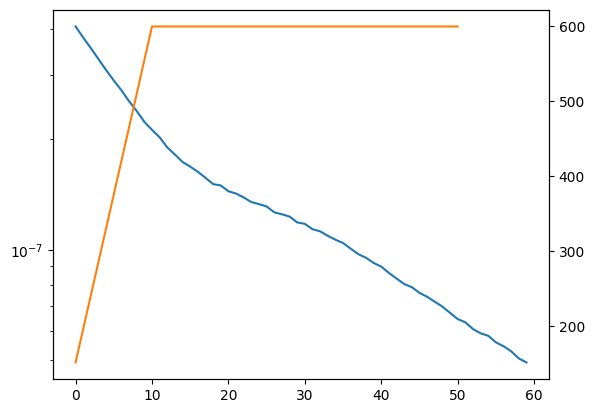

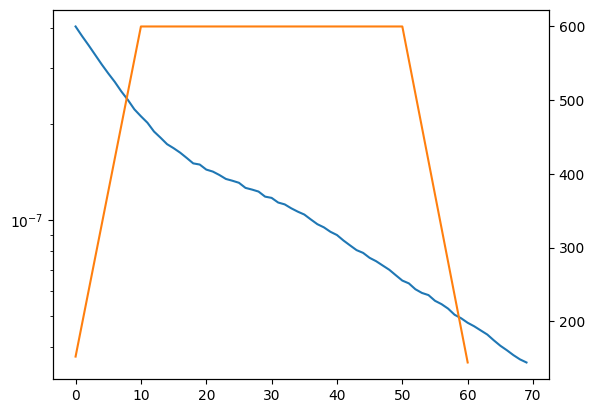

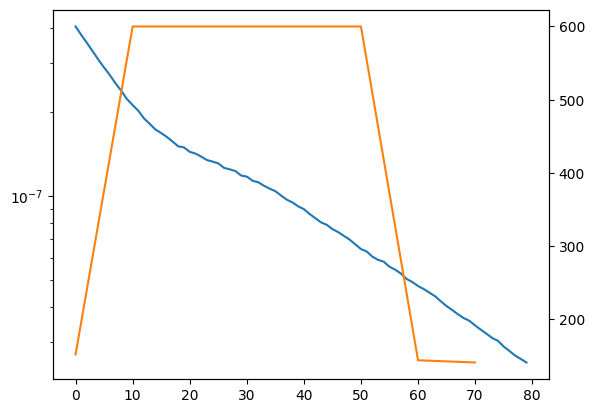

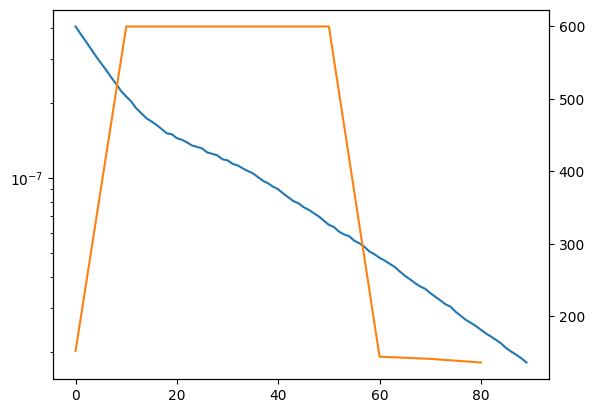

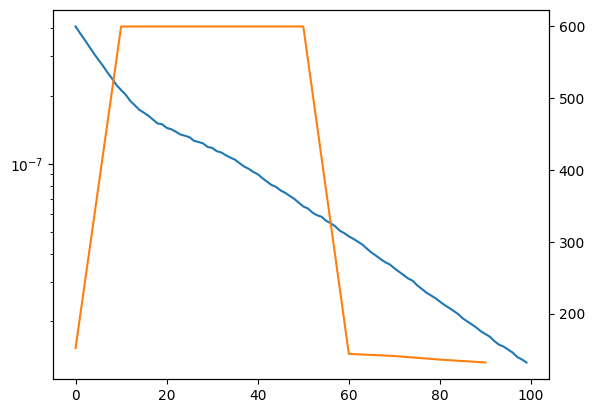

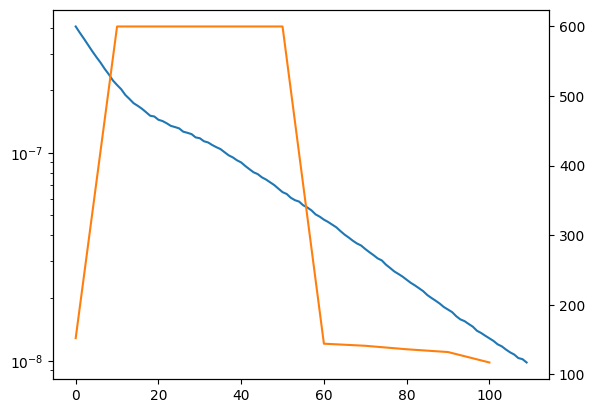

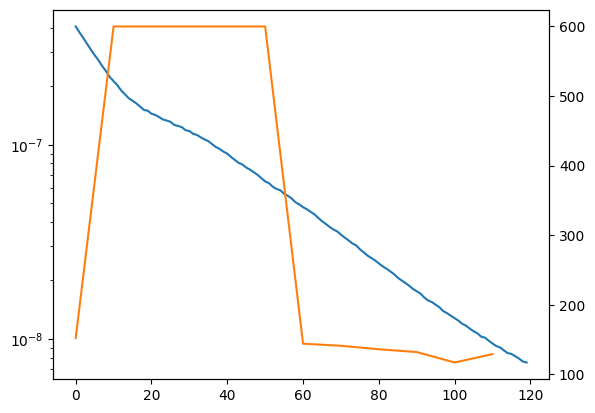

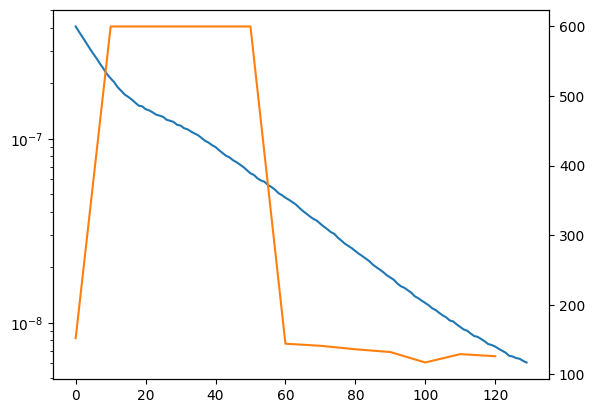

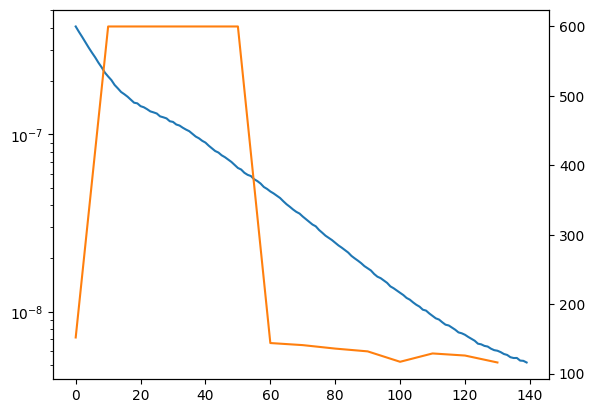

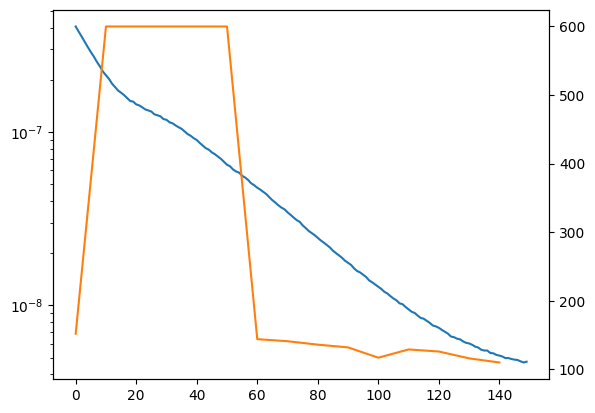

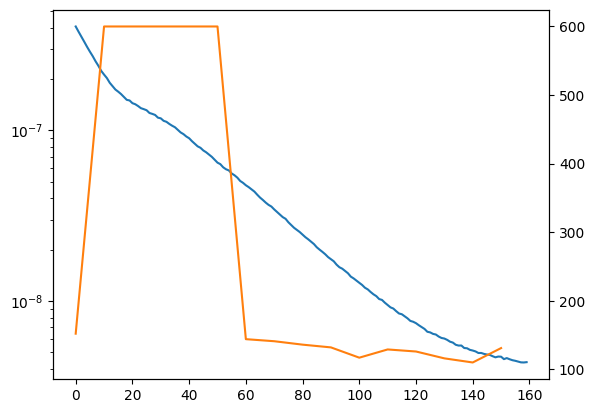

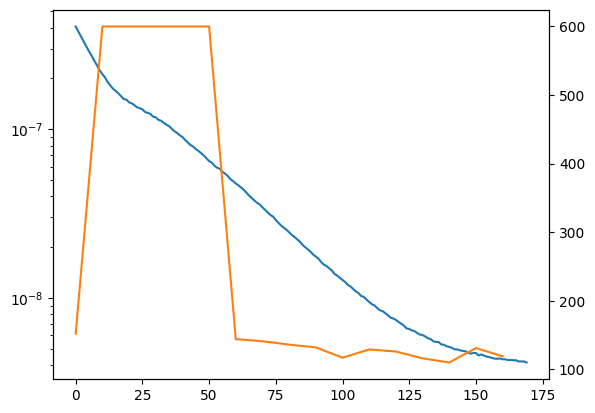

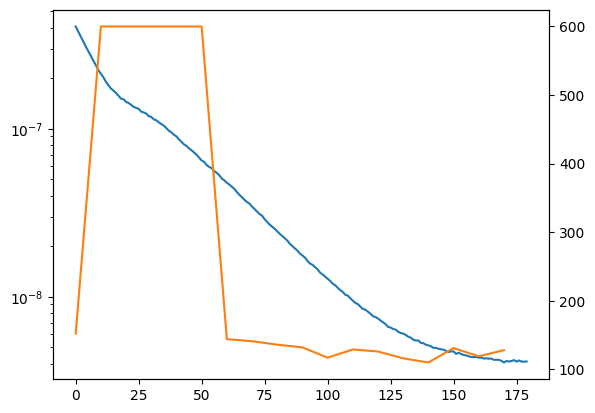

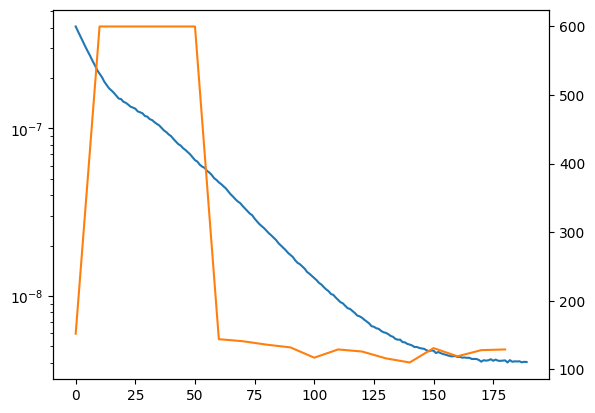

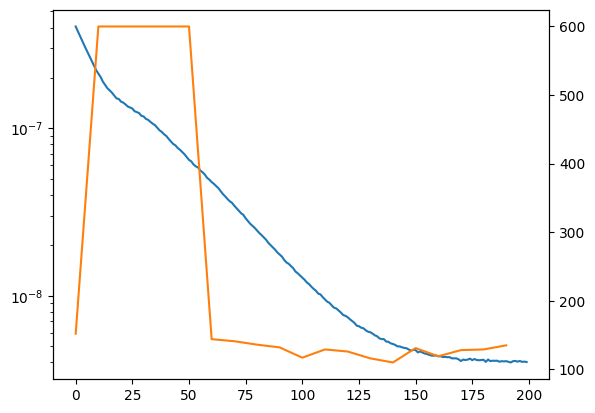

In [16]:
optimizer = torch.optim.Adam(layer.parameters(), lr=1e-2)

n_training = 200
check_every = 10
plot_every = 10

loss = np.zeros(n_training)
iterations_p = np.zeros(n_training // check_every)
ret_p = {"k": -1}

for t in range(1, n_training+1):
    vec = torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.cdouble)
    Dvec = w(vec)
    
    norm = l2norm(Dvec)
    Dvec = Dvec / norm
    vec = vec / norm
    
    sDvec = torch.stack([Dvec])
    score = complex_mse_loss(layer.forward(sDvec), torch.stack([vec]))
    print(f"  [{t:5d}|{t / n_training * 100:6.2f}%] <{score.item():.3e}|{ret_p['k']:5d}>", end="\r")
    loss[t-1] = score.item()
    optimizer.zero_grad()
    score.backward()
    optimizer.step()
    if t % check_every == 0:
        print(f"G [{t:5d}|{t / n_training * 100:6.2f}%] <{score.item():.3e}|{ret_p['k']:5d}>", end="\r")
        with torch.no_grad():
            x_p, ret_p = GMRES_restarted(w, vec, vec
                                         , prec=lambda v: layer.forward(torch.stack([v]))[0]
                                         , eps=1e-4, max_restart=20, maxiter_inner=30)
    
        iterations_p[t // check_every - 1] = ret_p["k"]

    print(f"  [{t:5d}|{t / n_training * 100:6.2f}%] <{score.item():.3e}|{ret_p['k']:5d}>", end="\r")
    if t % plot_every == 0:
        plt.plot(loss[0:t])
        plt.yscale("log")
        ax = plt.gca().twinx()
        ax.plot(np.arange(0, n_training, check_every)[0:t//check_every], iterations_p[0:t//check_every], "C1")
        plt.show()

print()

Text(0, 0.5, 'iterations required by GMRES')

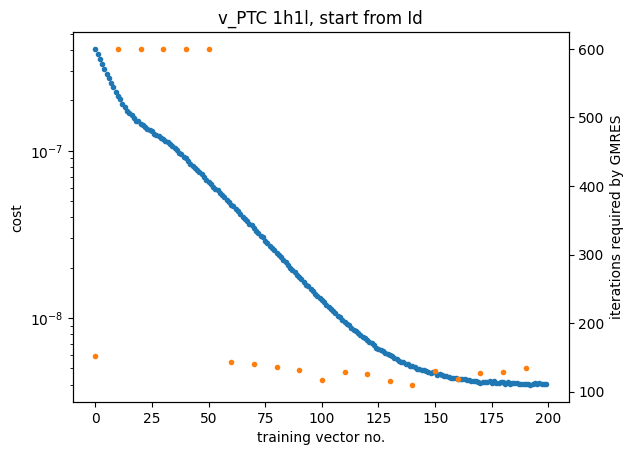

In [17]:
plt.plot(loss, ".")
plt.title("v_PTC 1h1l, start from Id")
plt.yscale("log")
plt.ylabel("cost")
plt.xlabel("training vector no.")
ax = plt.gca().twinx()
ax.plot(np.arange(0, n_training, check_every), iterations_p, "C1.")
ax.set_ylabel("iterations required by GMRES")


In [18]:
ret["k"] / ret_p["k"]

4.237037037037037

In [19]:
torch.save(layer.state_dict(), "ptc1h1l_start_id.pt")